## Arctic regions geospatial wrangling

The goal of these exercises is to refine the Arctic communities choropleth map created in the Reprojecting lesson to restrict the plotting to the Arctic relevant regions:

In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
"""
Set environment variable 'PROJ_LIB' to specify the path for the PROJ library
Resolves ERROR 1: PROJ: proj_create_from_database
"""""
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'
pd.set_option("display.max.columns", None)

# Load in data
df = gpd.read_file('/courses/EDS220/data/arctic_communities.geojson')

In [5]:
# Look at the head of the data
df.head(3)

,admin,country,n_communities,geometry
0,United States of America,US,115,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576..."
1,United Kingdom,GB,96,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51..."
2,Sweden,SE,133,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57..."


In [6]:
# Check the crs
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

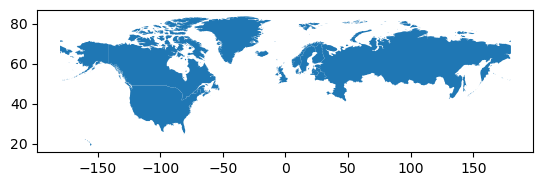

In [7]:
# Prelim plot
df.plot()

## Check geometries

In [14]:
# Check geometry types
list(df.geom_type.unique())

['MultiPolygon', 'Polygon']

In [17]:
# Create if-else statement
if list(df.geom_type.unique()) == 'Polygon':
    print("All features are polygons")
else:
    print("Multiple feature types")

All features are polygons


In [31]:
# Write function that receives a single geodataframe as its parameter and 
# prints out a message stating whether all the geometry types are polygons or not

def check_polygons(geodf):
    """
    Check for polygon geometry type in geodataframe
    
    Args:
        geodf: The geodataframe to check
    Returns:
        string: Message stating whether all geometry types are polygons or not
    """
    if list(geodf.geom_type.unique()) == ['Polygon']:
        print("All features are polygons")
    else:
        print("Multiple feature types")

In [25]:
# Test out function
check_polygons(df)

Multiple feature types


## Explode polygons

The `explode()` method splits multipart geometries into multiple single geometries, resulting in a longer GeoDataFrame. 

Parameters:

- column = Column to explode. In the case of a geometry column, multi-part geometries are converted to single-part. If None, the active geometry column is used.
- ignore_index = bool, default False: If True, the resulting index will be labelled 0, 1, …, n - 1, ignoring index_parts
- index_parts = boolean, default False: If True, the resulting index will be a multi-index (original index with an additional level indicating the multiple geometries: a new zero-based index for each single part geometry per multi-part geometry)

In [26]:
# Overwrite the df geodataframe with the output from the explode method with the 
# index_parts parameter set to False
df = df.explode(index_parts = False)

In [27]:
# Reset index
df.reset_index()

,index,admin,country,n_communities,geometry
0,0,United States of America,US,115,"POLYGON ((-132.74687 56.52568, -132.75762 56.5..."
1,0,United States of America,US,115,"POLYGON ((-132.77988 56.24727, -132.83096 56.2..."
2,0,United States of America,US,115,"POLYGON ((-134.31274 58.22891, -134.31987 58.2..."
3,0,United States of America,US,115,"POLYGON ((-145.11851 60.33711, -145.15049 60.3..."
4,0,United States of America,US,115,"POLYGON ((-144.56563 59.81841, -144.61357 59.8..."
...,...,...,...,...,...
476,13,Canada,CA,7,"POLYGON ((-109.16641 67.98237, -109.05391 67.9..."
477,13,Canada,CA,7,"POLYGON ((-108.09272 67.00518, -107.96646 66.9..."
478,13,Canada,CA,7,"POLYGON ((-109.32314 67.99087, -109.36084 67.9..."
479,13,Canada,CA,7,"POLYGON ((-139.04312 69.57690, -139.12573 69.5..."


In [32]:
# Check the explosion
check_polygons(df)

All features are polygons


## Compute minimum y-coordinate for polygons

In [35]:
# Select the first row of df using iloc. What kind of Python object is this?
df.iloc[0]

# This is a pandas series

admin                                     United States of America
country                                                         US
n_communities                                                  115
geometry         POLYGON ((-132.746875 56.525683593749996, -132...
Name: 0, dtype: object

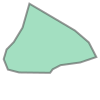

In [47]:
# Select the geometry of the first row of df. What kind of Python object is this?
df.iloc[0].geometry

# This is a polygon object?

In [48]:
# Use the bounds attribute for shapely Polygons to select the southern-most 
# bound of the first polygon in df.

df.iloc[0].geometry.bounds[1] # bounds[1] gives miny

56.511035156249996

In [49]:
# Create a function min_y that receives a single row of a geodataframe as its parameter and 
# returns the minimum y-coordinate of its bounding box.

def min_y(geodf_row):
    """
    Return the minimum y-coordinate of a geodataframes single row's bounding box
    
    Args:
        geodf_row: The row of the geodataframe
    Returns:
        minimum y-coordinate
    """
    return geodf_row.geometry.bounds[1]

In [50]:
min_y(df.iloc[0])

56.511035156249996

In [68]:
# Use the min_y function and the apply method for data frames to create a 
# new column miny in df which has the minimum y coordinate.

df['miny'] = df.apply(min_y, axis=1)

In [70]:
df.head(3)
# This doesn't look right??

,admin,country,n_communities,geometry,miny
0,United States of America,US,115,"POLYGON ((-132.74687 56.52568, -132.75762 56.5...",56.511035
0,United States of America,US,115,"POLYGON ((-132.77988 56.24727, -132.83096 56.2...",56.244141
0,United States of America,US,115,"POLYGON ((-134.31274 58.22891, -134.31987 58.2...",58.204102


## Filter, update CRS, and reproduce map

In [71]:
# Select the polygons with a bounding box 
# at or above 40 degrees of latitude into a new variable named arctic.

arctic = df[df.miny >= 40]

In [76]:
# update the CRS to EPSG:3413.
arctic = arctic.to_crs('epsg:3413')
arctic.crs

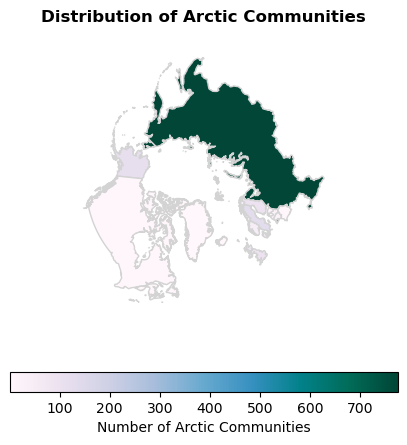

In [110]:
# recreate plot
fig, ax = plt.subplots(figsize = (5,5))
ax.axis('off')

arctic.plot(ax=ax,
           column='n_communities',
           cmap='PuBuGn',
           legend=True,
           edgecolor='lightgrey',
           legend_kwds={'label': "Number of Arctic Communities",
                       'orientation':'horizontal'})

ax.set_title("Distribution of Arctic Communities", fontsize=12, fontweight='bold')
fig.show()